# Кросс-валидация

## Настоящая магия
-------
### I. Введение

В удивительном мире Хогвартса наконец появились компьютеры, а вместе с ними и машинное обучение. Подоспевшая реформа магияческого образования оказала положительный эффект, позволив пед. составу открыть для себя совершенно новые методы работы. Особенно рад был Дамблдор, задумавший раз и навсегда изменить алгоритм распределения студентов по факультетам. Все-таки доверять столь важное дело головному убору странно и архаично.

Благодаря местному сисадмину Пете Дамблдор получил в свое распоряжение базовые библиотеки и сам массив данных по новым школьникам за предыдущий год, а также их распределение (считаем решения шляпы истинной в последней инстанции). 

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from matplotlib.colors import Colormap, ListedColormap
import seaborn as sns
plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import make_classification

X, y =  make_classification(n_samples=5000, n_classes=4, n_clusters_per_class=1, n_features=2, random_state=42,
                        n_redundant=0., weights=[0.4, 0.3, 0.2, 0.1], class_sep=0.6, flip_y=0.05, shuffle=True)
X = pd.DataFrame(X, columns=['wave frequency', 'emotional stability'])
X.index.name = 'Students'
y = pd.Series(y).map({0:'Gryffindor', 1:'Slytherin', 2:'Ravenclaw', 3:'Hufflepuff'}).to_frame('Faculty')
display(pd.concat([X, y], axis=1).head(10))

,wave frequency,emotional stability,Faculty
0,-1.575083,1.472224,Ravenclaw
1,-1.160340,-0.389483,Gryffindor
2,-1.565915,1.510910,Ravenclaw
3,1.043262,-0.592528,Slytherin
4,-1.620763,-0.901487,Gryffindor
5,1.841793,-0.698993,Slytherin
6,0.054838,0.059822,Ravenclaw
7,-2.256079,-2.098275,Gryffindor
8,0.132457,-0.121684,Gryffindor
9,-0.413599,-0.368362,Slytherin


Итак, вот она - верхушка ценнейших списков распределения студентов. Шляпа, к сожалению, отказалась выдавать Дамблдору секретные признаки, по которым происходит распределение. Однако самый главный в самой главной школе магии уверен - все дело в двух критериях: частоте волные магической палочки у каждого студента и его эмоциональной стабильности (ибо даже Дамблдор бережет психологическое здоровье учеников). 

Сначала думали посмотреть на общее распределение. Потом предложили построить график. В итоге решили совместить

In [3]:
labels = y.Faculty.map({0:'Gryffindor', 1:'Slytherin', 2:'Ravenclaw', 3:'Hufflepuff'})

In [4]:
palette = sns.color_palette(n_colors=4)
cmap = ListedColormap(palette)

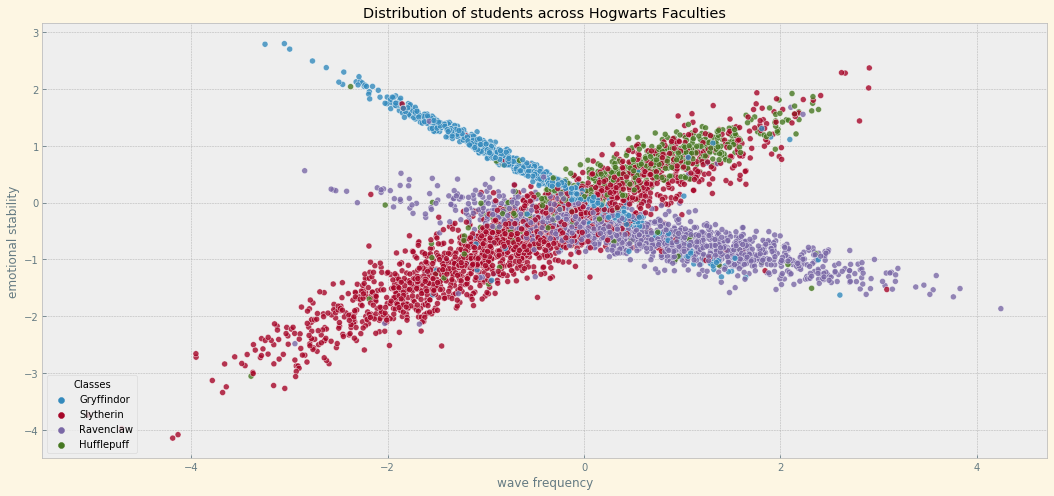

,Faculty
Gryffindor,1963
Slytherin,1484
Ravenclaw,1005
Hufflepuff,548


In [19]:
fig, ax = plt.subplots(figsize=(18, 8))
scatter = sns.scatterplot(X.iloc[:, 0], X.iloc[:, 1], hue=np.array(y.Faculty), cmap=cmap, marker="o", alpha=0.8)
legend_labels, _= scatter.get_legend_handles_labels()
legend1 = ax.legend(legend_labels, ['Gryffindor', 'Slytherin', 'Ravenclaw', 'Hufflepuff'],    
                    loc="lower left", title="Classes")
ax.set(title='Distribution of students across Hogwarts Faculties')
plt.show()
display(pd.DataFrame(y.Faculty.value_counts()))

_Сразу скажем, что данная версия была создана после дедлайна. На 99% она состоит из кода, написанного до 12 часов. Однако чувство прекрасного заставило автора в некоторых блоках кода дополнить `print` текстом с целью более доступного объяснения происходящего. Сам код в цикилах не менялся, если не сказано иное. Любые дальнейшие изменения после дедлайна были указаны и отмечены._

### II. Дамблдор с гранатой

Доподлинно известно, что программист, непонимающий суть происодящего за кодом, - худший кошмар остальных программистов. К сожалению, Дамблдор решил не заморачиваться с изучением основ, а просто скопировал с первого попавшегося сайта образцы разных CV алгоритмов. 

In [11]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, RepeatedStratifiedKFold, StratifiedShuffleSplit,PredefinedSplit
from sklearn.model_selection import StratifiedKFold, ShuffleSplit, RepeatedKFold
from sklearn.metrics import make_scorer, accuracy_score 


DT = DecisionTreeClassifier(random_state=42)
for i, cv in enumerate([2, KFold(10), StratifiedKFold(10)]):
    tmp = cross_validate(DT, np.array(X), np.array(y), return_train_score=True,
                         scoring=make_scorer(accuracy_score), cv=cv)
    print('Accuracy at training set with', cv, 'is equal to', tmp['train_score'].mean())

Accuracy at training set with 2 is equal to 1.0
Accuracy at training set with KFold(n_splits=10, random_state=None, shuffle=False) is equal to 1.0
Accuracy at training set with StratifiedKFold(n_splits=10, random_state=None, shuffle=False) is equal to 1.0


Конечно, accuracy равная единице не могла не обрадовать директора. Такой успех! Теперь точно жди медаль от магического министерства образования. Кто бы мог придумать более удачной оптимизации, совершенно без потерь для процесса.

Однако недовольная шляпа даже и не думала сдаваться: она верно подметила, что директор оценивает качество по обучающей выборке. На аргументы Дамблдора, что это тоже показатель, шляпа ответила решительно: решающие деревья практически всегда обеспечивают высокую accuracy из-за переобучения.

Пришлось перепроверять на тестовых данных.

_Заметим, что в виде CV при разбиении на два называется HoldOut CV, что не совсем верно, так как последняя не предполагает смены ролей выборок._

In [13]:
from sklearn.model_selection import cross_val_score

for i, cv in enumerate([2, KFold(10), StratifiedKFold(10), 
                        RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42),
                       StratifiedShuffleSplit(n_splits=10, test_size=.25, random_state=42)]):
    CV = cross_val_score(DT, np.array(X), np.array(y), cv=cv, scoring=make_scorer(accuracy_score))
    print('Accuracy at test set with', cv, 'is equal to',CV.mean())

Accuracy at test set with 2 is equal to 0.7028
Accuracy at test set with KFold(n_splits=10, random_state=None, shuffle=False) is equal to 0.6937999999999999
Accuracy at test set with StratifiedKFold(n_splits=10, random_state=None, shuffle=False) is equal to 0.7
Accuracy at test set with RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42) is equal to 0.69628
Accuracy at test set with StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.25,
            train_size=None) is equal to 0.6980000000000001


К большому разочарованию Дамблдора, тестовая выборка буквально оказалась палкой в колесах прогресса. Но профессор Снегг решил придти на помощь своему начальству (мотивы его пока что туманны). Его козырем в рукаве оказался алгоритм `GridSearchCV`, с помощью которого было принято решение найти оптимальные гиперпараметры для решающего дерева (других подходов Дамблдор не знал, а потому, как это обычно и бывает в бюрократических бюджетных организациях, всем приходилось работать исключительно с `DecisionTree`).

In [14]:
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
tree_param = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clf = GridSearchCV(DecisionTreeClassifier(criterion='entropy'), tree_param, cv=5, scoring=make_scorer(accuracy_score), refit=True)
clf.fit(X_train, y_train)
clf.best_params_

{'max_depth': 6}

_Был добавлен `plt.figure` для установления подходящего размера, сам код не менялся. Надо отметить, что хоть код и был написан до дедлайна, запустить его смог только автор, поэтому в первоначальном видео он не присутствовал, но был в ноутбуке._

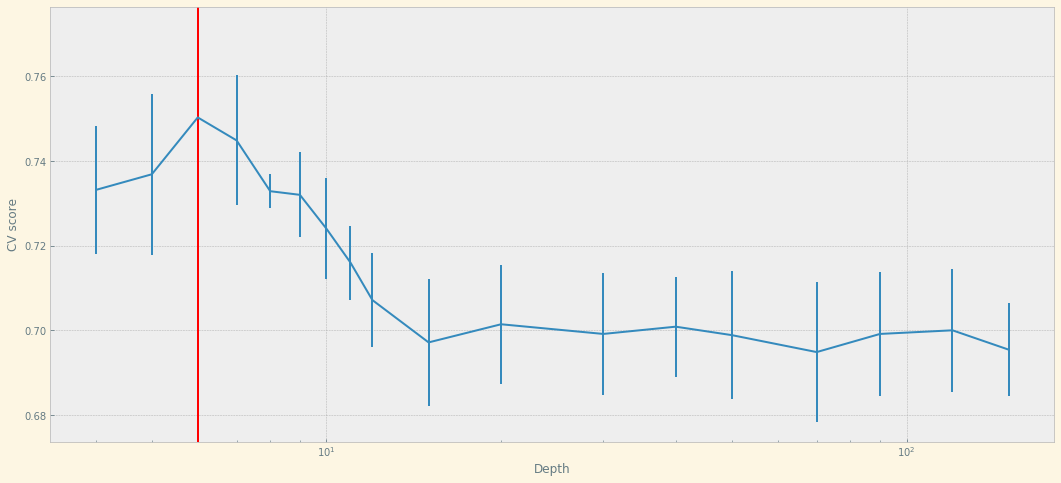

In [20]:
plt.figure(figsize=(18, 8))
plt.errorbar(x=[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
             y=clf.cv_results_["mean_test_score"], yerr=clf.cv_results_['std_test_score'])
plt.xscale("log")
plt.xlabel("Depth")
plt.ylabel("CV score")
plt.axvline(x=clf.best_params_['max_depth'], c='red')
plt.show()

In [21]:
for i, cv in enumerate([2, KFold(10), StratifiedKFold(10), 
                        RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42),
                       StratifiedShuffleSplit(n_splits=10, test_size=.25, random_state=42)]):
    DT = DecisionTreeClassifier(**clf.best_params_)
    CV = cross_val_score(DT, np.array(X), np.array(y), cv=cv, scoring=make_scorer(accuracy_score))
    print('Accuracy at training set with', cv, 'is equal to',CV.mean())

Accuracy at training set with 2 is equal to 0.743
Accuracy at training set with KFold(n_splits=10, random_state=None, shuffle=False) is equal to 0.7449999999999999
Accuracy at training set with StratifiedKFold(n_splits=10, random_state=None, shuffle=False) is equal to 0.7486
Accuracy at training set with RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42) is equal to 0.7482799999999997
Accuracy at training set with StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.25,
            train_size=None) is equal to 0.7526400000000002


75% accuracy. С одной стороны, результат не самый высокий по сравнению с всезнающей шляпой. С другой стороны, больше никаких колких заявлений и полная вертикаль власти. Так или иначе, а результат Дамблдора устроил. Более того, он еще неделю смеялся над программистами, разработавших столько реализаций CV, который дают одиннаковые результаты.

Сисадмин Петя, в свою очередь, решил по собственной инициативе построить графики для отчета в Мин.Маг.Образования. Несмотря на долгие объяснения паренька, директор так и не понял, в чем проблема высокой `std`. Зато все предельно хорошо понял друг сисадмина, лидер студенческой организации - оценка целого волшебника по двум признакам очень ненадежная, а главная дискриминирующая затея. Поэтому и предсказание целевой переменной оказываются не близкими к изначальным.

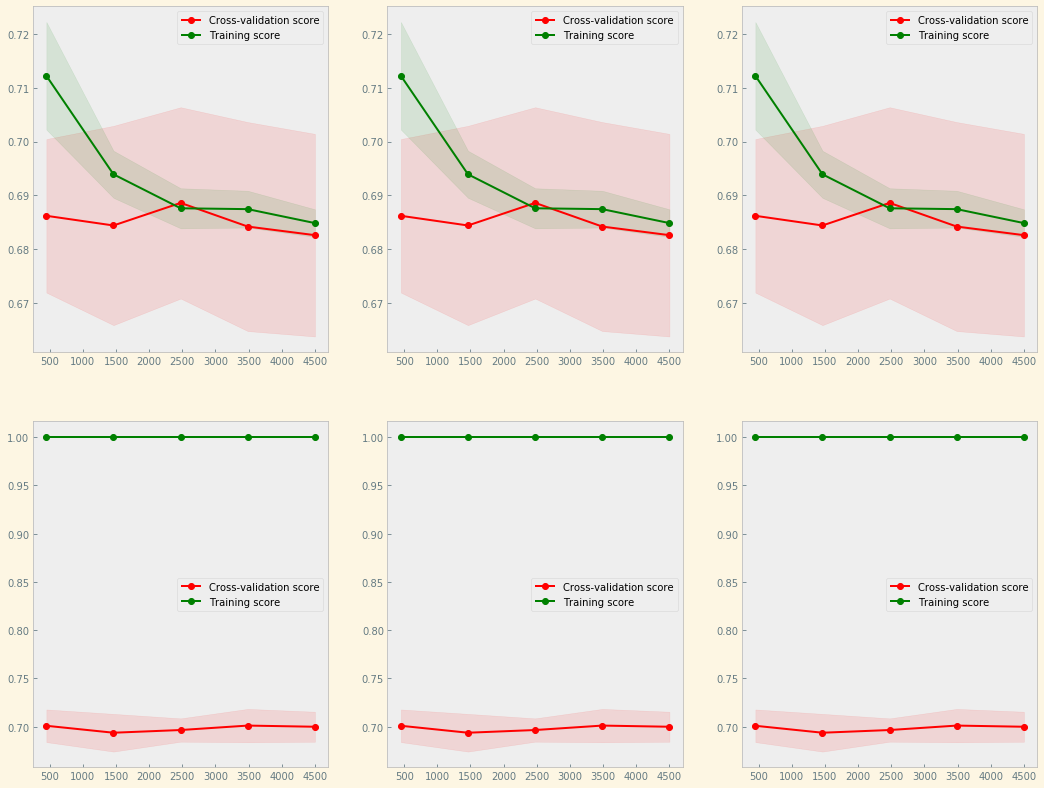

In [22]:
from sklearn.model_selection import learning_curve
from sklearn.naive_bayes import GaussianNB

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18, 14))
for j, estimator in enumerate([GaussianNB(), DecisionTreeClassifier(random_state=42)]):
    for i, cv in enumerate([KFold(2), KFold(10), StratifiedKFold(10)]):
        train_size, train_scores, test_scores = learning_curve(
            estimator, np.array(X), np.array(y), cv=StratifiedKFold(10), n_jobs=4
        )
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax[j][i].grid()
        ax[j][i].fill_between(train_size, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.1, color='r')
        ax[j][i].fill_between(
                train_size,
                train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std,
                alpha=0.1,
                color="g",
            )
        ax[j][i].plot(
                train_size, test_scores_mean, "o-", color="r", label="Cross-validation score"
            )
        ax[j][i].plot(
                train_size, train_scores_mean, "o-", color="g", label="Training score"
            )
        ax[j][i].legend(loc="best")

### III. На волне успеха

Почувствовав себя снова идущим в ногу со временем, словно 300 лет назад, Дамблдор решил закрыть еще один свой гештальт, но уже более личного характера. Дело в том, что у директора уже много лет длилось жестокое противостояние с небезызвестным профессором Снеггом, а именно - крестики-нолики. Профессор решил объединить все сыгранные партии в один массив данных и с помощью все той же кросс-валидации научится наиболее эффективно предугадывать сценарии развития партий.

In [23]:
from sklearn import preprocessing


def saying_too_late_about_func(X):
    le = preprocessing.LabelEncoder()
    for feat in X.columns:
        X[feat] = le.fit_transform(X[feat])
    return X

In [24]:
ticy_taca = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data',
                        sep=',', header=None)
X_tt = saying_too_late_about_func(ticy_taca.drop(ticy_taca.columns[-1], axis=1))
y_tt = ticy_taca[ticy_taca.columns[-1]].map({'positive': 1, 'negative':0})

In [25]:
DT = DecisionTreeClassifier(random_state=42)
for cv in [2, KFold(10), 10]:
    result = (cross_val_score(DT, np.array(X_tt), np.array(y_tt), cv=cv, 
                                 scoring=make_scorer(accuracy_score))).mean()
    print('Accuracy with', cv, 'is equal to',result)

Accuracy with 2 is equal to 0.5490605427974948
Accuracy with KFold(n_splits=10, random_state=None, shuffle=False) is equal to 0.4717434210526316
Accuracy with 10 is equal to 0.7716776315789474


Провал! Столь хорошо работавшие базовые методы CV почему-то перестали приносить результат. Accuracy в районе 50% не позволяла получить Дамблдору даже малейшего перевеса в противостоянии. Директор был очень расстроен и даже на неделю объявил локдаун в Хогвартсе, чтобы побыть одному и погрустить.

В то же время, профессор Снегг, обладающий удивительной чуйкой, с помощью магических заклинаний (и пароля от компьютера Дамблдора) решил так же использовать классификтора и CV для победы в противостоянии. Однако, будучи не столь старым "юзером", Снегг смог разобраться во всех тонкостях нового ремесла и учесть ошибки конкурента. Вот что из этого вышло:

In [26]:
encoded = saying_too_late_about_func(ticy_taca.drop(ticy_taca.columns[-1], axis=1))
encoded['ps'] = encoded.index % 10
ps = PredefinedSplit(encoded['ps'])

skf = StratifiedKFold(n_splits=10, shuffle=True)

In [27]:
for i, args in enumerate([ps, skf, RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42),
                       StratifiedShuffleSplit(n_splits=10, test_size=.25, random_state=42)]):
    print('Experiments for tic-tac-toe with', args)
    print((cross_val_score(DT, np.array(X_tt), np.array(y_tt), cv=args, 
                             scoring=make_scorer(accuracy_score))).mean())
    print()

Experiments for tic-tac-toe with PredefinedSplit(test_fold=array([0, 1, ..., 6, 7]))
0.8903837719298245

Experiments for tic-tac-toe with StratifiedKFold(n_splits=10, random_state=None, shuffle=True)
0.865219298245614

Experiments for tic-tac-toe with RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42)
0.8822609649122808

Experiments for tic-tac-toe with StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.25,
            train_size=None)
0.8766666666666667



### IV. Несогласные

Пока Дамблдор и весь сопричастный пед. состав занимались бог знает чем, среди учеников зарождалось недовольство - мол, несправедливо это оценивать людей по каким-то придуманным признакам, да еще и держащимся в тайне от масс. Новое движение "Нет Цифровой диктатуре" объявила всеобщую забастовку, целью которой было изменить действующую политику руководства.

Перепугавшийся Дамблдор, совершенно не желавший на склоне лет омрачать заветную почетную пенсию, согласился пойти на уступки. Помимо улучшения качества обедов в столовой, были так же и следующие требования:

1) Расширения числа параметров оценки студента для более эффективного распределения по факультетам

2) Открытые данные и независимая оценка признаков для каждого студента

3) Использование Leave-p-out CV (Дамблдор не знал что это, а потому согласился)

In [108]:
X, y =  make_classification(n_samples=5000, n_classes=4, n_clusters_per_class=1, n_features=8, random_state=42,
                        n_redundant=1, n_repeated=1, weights=[0.4, 0.3, 0.2, 0.1], class_sep=0.9, flip_y=0.03, shuffle=True)
X = pd.DataFrame(X)
X.index.name = 'Students'
y = pd.Series(y).map({0:'Gryffindor', 1:'Slytherin', 2:'Ravenclaw', 3:'Hufflepuff'}).to_frame('Faculty')
y.index.name = 'Students'
display(pd.concat([X, y], axis=1).head(10))

,0,1,2,3,4,5,6,7,Faculty
Students,,,,,,,,,
0,0.629536,-1.732415,-0.177214,-2.155977,1.286553,1.989383,-2.155977,0.298915,Ravenclaw
1,-0.448648,0.595044,0.521275,0.673754,0.397151,0.639528,0.673754,1.017056,Hufflepuff
2,-1.542330,-1.697652,-1.124277,-1.900877,0.274401,-2.247266,-1.900877,0.150523,Gryffindor
3,0.146306,-0.621520,2.129156,-0.674985,-0.737247,-1.237510,-0.674985,0.108498,Gryffindor
4,1.335452,1.509268,1.243960,1.737500,0.783984,1.055709,1.737500,-0.605517,Hufflepuff
5,-1.876998,1.462719,-0.050804,1.805742,1.200046,-1.390425,1.805742,-0.271245,Slytherin
6,-2.325233,-0.865186,0.089073,-1.079066,-0.217567,1.040066,-1.079066,0.210362,Ravenclaw
7,-0.237976,-0.335145,-0.062180,-0.368901,-0.303439,-0.569705,-0.368901,-0.800641,Gryffindor
8,-1.453095,-1.352485,0.425376,-1.684607,0.618622,1.581845,-1.684607,0.745879,Ravenclaw


Благо во время в процесс включился Петя, парень хороший, но наивный. Он посчитал, что придется выполнить $$C^2_{5000} = 12497500$$ операций. Другими словами, вся система компьютерной безопасности Хогвартса накрылась бы еще до прихода Волан-де-Морта. Поэтому решили так: новые алгоритмы применить к 500 инициативным ученикам, подавшим жалобу (они были первые в списке). Ну а сидевших в стороне эта милость обошла, придется довериться изначальной модели.

_Изначально была допущена ошибка и вычисления проводились лишь для 100 студентов. В коде, представляемом после  дедлайна, данное значение заменено на 500. Остальной код не менялся._

In [32]:
from sklearn.model_selection import LeavePOut
import time

start = time.time()
lpo = LeavePOut(2)
result = (cross_val_score(DT, np.array(X.loc[0:500, :]), np.array(y.loc[0:500, :]), cv=lpo, 
                                 scoring=make_scorer(accuracy_score))).mean()
print('Time taken is', time.time() - start)
print('Mean accuracy score for the extended dataset is', result)

Time taken is 610.9510478973389
Mean accuracy score for the extended dataset is 0.7665668662674651


### V. Хитрый Снегг

Пока у студенчества шла борьба с директором за свободу и т.п., профессор Снегг решил скрасить себе жизнь и, так сказать, реализовать давние комплексы - сделать Слизерин самым сильным факультетом. Для этого он решил использовать регрессию и постараться угадать самых умных (в рамках оценок) студентов. Конечно, в природе существовали истинные значения весов, но, увы и ах, даже волшебникам их не найти. Поэтому статистика.

_Ниже добавлена строчка с превращениям `marks` в ` DataFrame`._

In [109]:
marks = X[0] * 1.37 + X[1] * (-2.36) + X[2] * 0.001 + X[3] * 4.29 + X[4] * (-3.97) + X[5] * 6.28 + X[6] * (-0.3) + X[7] * (-5.3)
marks = marks.to_frame('Marks')

In [110]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, marks, test_size=0.3, random_state=42)
tree_param = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
clfr = GridSearchCV(DecisionTreeRegressor(), tree_param, cv=5, refit=True)
clfr.fit(X_train, y_train)
clfr.best_params_

{'max_depth': 50}

_Аналогичная ситуация с предыдущим графиков - код был написан до дедлайна, но запустил его только автор уже после 12 часов (когда, надеюсь, карета еще не превратилась...)_

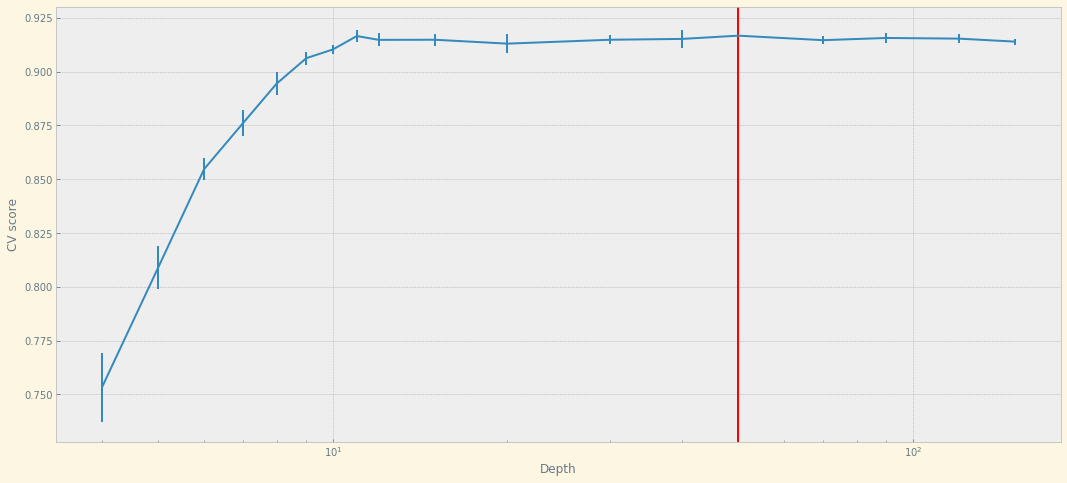

In [111]:
plt.figure(figsize=(18, 8))
plt.errorbar(x=[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
             y=clfr.cv_results_["mean_test_score"], yerr=clfr.cv_results_['std_test_score'])
plt.xscale("log")
plt.xlabel("Depth")
plt.ylabel("CV score")
plt.axvline(x=clfr.best_params_['max_depth'], c='red')
plt.show()

In [112]:
for i, cv in enumerate([2, KFold(10),
                        RepeatedKFold(n_splits=10, n_repeats=5, random_state=42),
                       ShuffleSplit(n_splits=10, test_size=.25, random_state=42)]):
    DT = DecisionTreeRegressor(**clfr.best_params_)
    CV = cross_val_score(DT, np.array(X), np.array(marks), cv=cv)
    print('Score at test set with', cv, 'is equal to',CV.mean())

Score at test set with 2 is equal to 0.9053642555982709
Score at test set with KFold(n_splits=10, random_state=None, shuffle=False) is equal to 0.924195477688056
Score at test set with RepeatedKFold(n_repeats=5, n_splits=10, random_state=42) is equal to 0.9254641308071812
Score at test set with ShuffleSplit(n_splits=10, random_state=42, test_size=0.25, train_size=None) is equal to 0.9209835110611106


_Основной код был написан до дедлайна, после были привнесены небольшие корректировки (например, добавлен `y` в `df`) с целью завершения задачи. Справедливо будет, если данная часть проигнорируется проверяющим, но желание закончить дело не позволило забросить последнюю главу._

In [113]:
from sklearn.model_selection import cross_val_predict

X['predict'] = pd.DataFrame(cross_val_predict(DT, np.array(X), np.array(marks), 
                                           cv=KFold(10),
                                           ))
df = pd.concat([X, marks, y], axis=1)
df.sort_values(by=['predict'], inplace=True, ascending=False)
df.reset_index(inplace=True, drop=True)
df = df.loc[1484:]

In [114]:
DT = DecisionTreeClassifier(random_state=42)
for i, cv in enumerate([2, KFold(10), StratifiedKFold(10), 
                        RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42),
                       StratifiedShuffleSplit(n_splits=10, test_size=.25, random_state=42)]):
    DT = DecisionTreeClassifier(**clf.best_params_)
    CV = cross_val_score(DT, np.array(df.drop(['predict', 'Marks', 'Faculty'], axis=1)), np.array(df.Faculty),
                         cv=cv, scoring=make_scorer(accuracy_score))
    print('Accuracy at training set with', cv, 'is equal to',CV.mean())

Accuracy at training set with 2 is equal to 0.7733219567690557
Accuracy at training set with KFold(n_splits=10, random_state=None, shuffle=False) is equal to 0.8359549015799015
Accuracy at training set with StratifiedKFold(n_splits=10, random_state=None, shuffle=False) is equal to 0.8373332685832686
Accuracy at training set with RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42) is equal to 0.8391914335664336
Accuracy at training set with StratifiedShuffleSplit(n_splits=10, random_state=42, test_size=0.25,
            train_size=None) is equal to 0.8350398179749716
